In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import sys
import glob
import matplotlib as mpl
import math

from PIL import Image, ImageDraw, ImageFont, ImageChops

In [3]:
sys.path.append('../../../Libraries/')

In [4]:
from Utils.Toolbox import graphics

In [5]:
rootPath = '../data/'

# OVERALL

In [6]:
alld = pd.read_csv("../data/all_data.csv")
alld.shape

/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(54471, 30)

In [7]:
alld.shape

(54471, 30)

In [8]:
#graphics.draw_scanpath(Image.new("RGB", (1920, 1080), "gray"), scanpath)

# X&Y

### Overall look

First of all, let's look for stats of those outliers

In [9]:
alld.columns

Index(['CALIBRATION_PROBLEM', 'CONDITION', 'CURRENT_FIX_BLINK_AROUND',
       'CURRENT_FIX_DURATION', 'CURRENT_FIX_END', 'CURRENT_FIX_START',
       'CURRENT_FIX_X', 'CURRENT_FIX_Y', 'DATETIME', 'DISTRACTOR', 'EYE_USED',
       'IP_INDEX', 'IP_LABEL', 'NEXT_SAC_AMPLITUDE', 'NEXT_SAC_ANGLE',
       'NEXT_SAC_AVG_VELOCITY', 'NEXT_SAC_BLINK_DURATION',
       'NEXT_SAC_BLINK_END', 'NEXT_SAC_BLINK_START', 'NEXT_SAC_CONTAINS_BLINK',
       'NEXT_SAC_DIRECTION', 'NEXT_SAC_DURATION', 'NEXT_SAC_END_X',
       'NEXT_SAC_END_Y', 'OFFSET', 'PART_ID', 'TASK', 'TRIAL_INDEX',
       'WEBSITE_ID', 'Y_OFFSET'],
      dtype='object')

In [10]:
def count_errors(group):
    count = group.query("CURRENT_FIX_X < 0 or CURRENT_FIX_X > 1920 or CURRENT_FIX_Y < 0 or CURRENT_FIX_Y > 1080")["EYE_USED"].count()
    group["error_ratio"] = count / group.shape[0]
    return group

# Compute the overall ratio of fixations outside the screen on the full dataset
alld = alld.groupby(["PART_ID","TRIAL_INDEX"]).apply(count_errors)

error_ratio    0.007907
dtype: float64


TRIAL_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
error_ratio,0.005043,0.004732,0.004031,0.006008,0.002704,0.004573,0.005177,0.009979,0.005415,0.00571,0.011026,0.008559,0.003729,0.030109,0.008286,0.006252,0.012241,0.008751


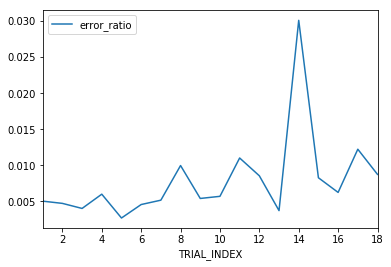

In [11]:
# Mean error rate by trial
calcul_by = "TRIAL_INDEX"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.008033
dtype: float64


PART_ID,1,2,3,4,7,8,10,11,709,710,711,712,713,714,715,716
error_ratio,0.000633,0.005193,0.002438,0.004673,0.003955,0.002237,0.000348,0.004332,0.00726,0.029678,0.029252,0.01539,0.008021,0.003654,0.005207,0.006264


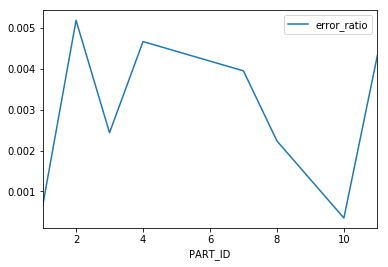

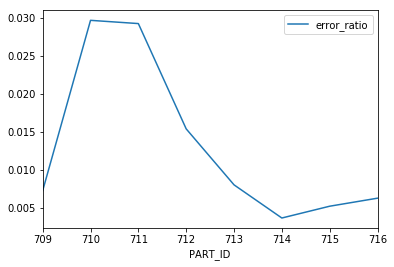

In [12]:
# Mean error rate by Participant
calcul_by = "PART_ID"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).query("PART_ID < 700").plot()
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).query("PART_ID > 700").plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.007959
dtype: float64


CONDITION,1,2,3,4,5,6
error_ratio,0.007869,0.008346,0.005996,0.012163,0.004945,0.008436


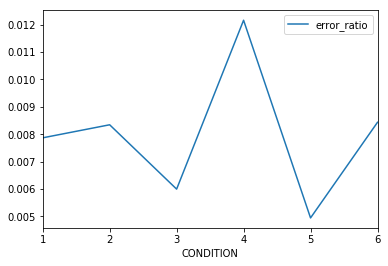

In [13]:
# Mean error rate by Condition
calcul_by = "CONDITION"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

In [14]:
alld["TASK"] = 'Target'
alld.loc[alld.query("CONDITION in [1,3,5]").index, "TASK"] = "Free"

error_ratio    0.007979
dtype: float64


TASK,Free,Target
error_ratio,0.006258,0.0097


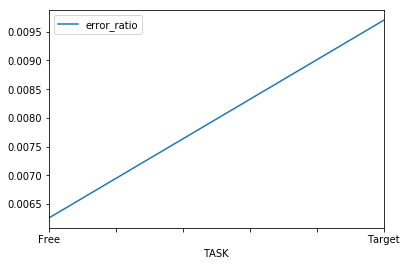

In [15]:
# Mean error rate by trial
calcul_by = "TASK"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

We can see that participants have a higher rate of error even if it is not very big. Let's look how it turns when we remove participants 710, 711 and then 7th. 

### 710 and 711

error_ratio    0.004931
dtype: float64


TRIAL_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
error_ratio,0.005816,0.00476,0.003928,0.003065,0.001761,0.004223,0.005298,0.004979,0.006081,0.004108,0.00813,0.005834,0.002884,0.006748,0.002674,0.006609,0.008935,0.00293


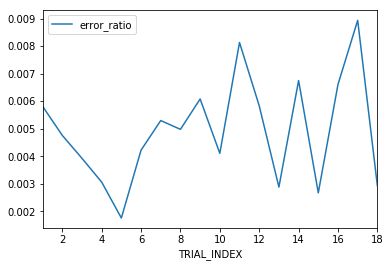

In [16]:
# Mean error rate by trial
calcul_by = "TRIAL_INDEX"
parts_to_drop = [710, 711]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.005072
dtype: float64


CONDITION,1,2,3,4,5,6
error_ratio,0.003806,0.005594,0.004686,0.006354,0.004092,0.005898


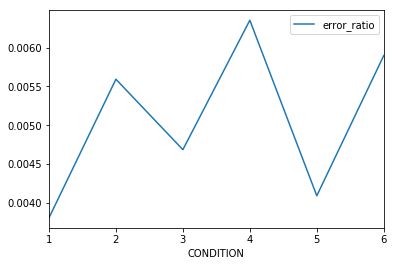

In [17]:
# Mean error rate by trial
calcul_by = "CONDITION"
parts_to_drop = [710, 711]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

### 710, 711 and 7

error_ratio    0.004999
dtype: float64


TRIAL_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
error_ratio,0.004822,0.005195,0.004209,0.003183,0.00193,0.004733,0.00543,0.005444,0.005503,0.003096,0.008413,0.006017,0.002721,0.007098,0.002504,0.007194,0.009885,0.002612


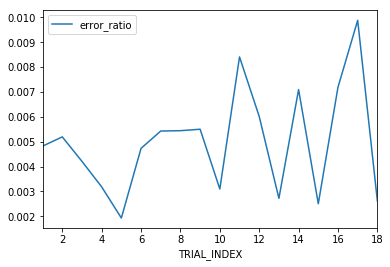

In [18]:
# Mean error rate by trial
calcul_by = "TRIAL_INDEX"
parts_to_drop = [710, 711, 7]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.005174
dtype: float64


CONDITION,1,2,3,4,5,6
error_ratio,0.003511,0.005437,0.004951,0.006871,0.004102,0.006172


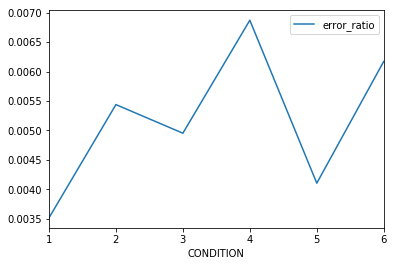

In [19]:
# Mean error rate by trial
calcul_by = "CONDITION"
parts_to_drop = [710, 711, 7]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

## Single participant: PART_1

Participant n°1 is the one with the minimum error ration (0.002), so let's investigate the easy case before looking for more complicated cases

In [20]:
df1 = alld.query("PART_ID == 1").copy()
df1.shape

(3162, 31)

In [21]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_X < 0")["EYE_USED"].count()

0

No look on the left of the screen

In [22]:
# Number of looks on the RIGHT of the screen
df1.query("CURRENT_FIX_X > 1920")["EYE_USED"].count()

2

In [23]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_Y < 0")["EYE_USED"].count()

0

In [24]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_Y > 1080")["EYE_USED"].count()

0

Are these related to a blink ?

**RIGHT**

In [25]:
# Count of blinks during the saccade
df1.query("CURRENT_FIX_X > 1920").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["EYE_USED"].count()

0

In [26]:
df1.query("CURRENT_FIX_X > 1920")

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio
43572,No,2,NONE,113,NaN,31337.0,1930.8,281.8,2018-04-03 14:56:31.574,NoAd,...,61.0,1881.5,573.5,5937,1,Target,3,3,6218.8,0.006645
43577,No,2,NONE,439,NaN,33726.0,1938.6,94.7,2018-04-03 14:56:33.963,NoAd,...,55.0,1555.9,15.5,5427,1,Target,3,3,5521.7,0.006645


In [27]:
# Is there a blink around ?
df1.ix[37580:37595]

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio


No blink around, so let's check how far the participant looked

-- RIGHT -- 
Mean distance outside the screen is 14.7px (0.42°)
Mean start time is 32.53s


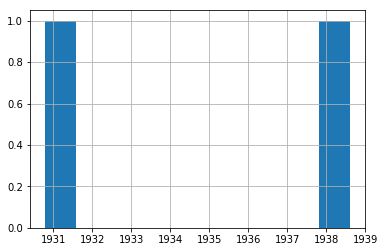

In [28]:
d = (df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"] - 1920).mean()
s = df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_START"].mean()
print("-- RIGHT -- ")
print("Mean distance outside the screen is {}px ({}°)".format(round(d, 2), round(d/35, 2)))
print("Mean start time is {}s".format(round(s/1000, 2)))
df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].hist()

In [29]:
# Degree error of each error
(df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"] - 1920)/35

43572    0.308571
43577    0.531429
Name: CURRENT_FIX_X, dtype: float64

**Since the fovea is 2-3° we can consider this type of outlier (<1°) can be edited to max value of X (1920).**

**DOWN**

In [30]:
# Count of blinks during the saccade
df1.query("CURRENT_FIX_Y > 1080").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["EYE_USED"].count()

0

In [31]:
df1.query("CURRENT_FIX_Y > 1080")

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio


The second fixation contains blinks in both rows after and before so let's investigate on this one first

In [32]:
df1.ix[40110:40115]

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio


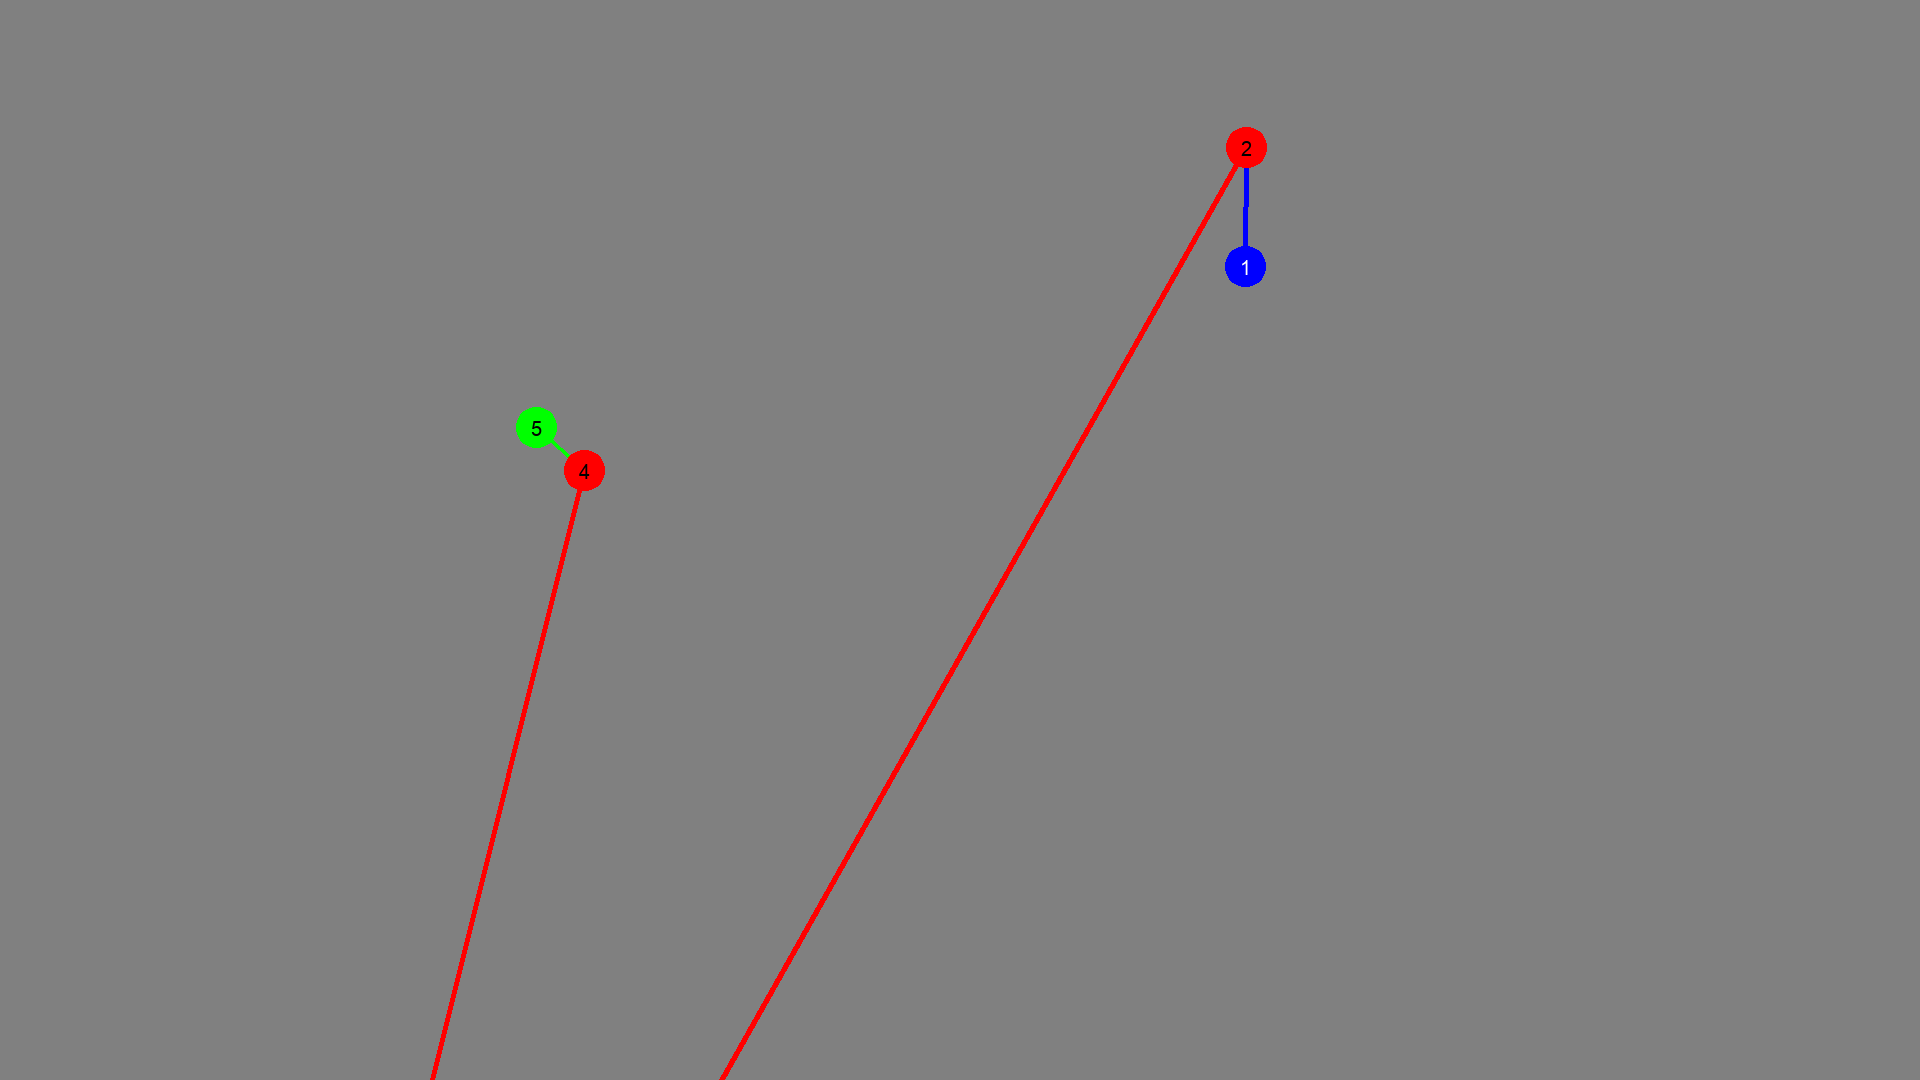

In [33]:
graphics.draw_scanpath(Image.new("RGB", (1920, 1080), "gray"), [
    [1245, 266],
    [1246, 147],
    [202, 2003],
    [584, 470],
    [536, 427],
])

This problem looks more like a blink issue than fixation outside the screen

In [34]:
df1.ix[39366:39370]

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio


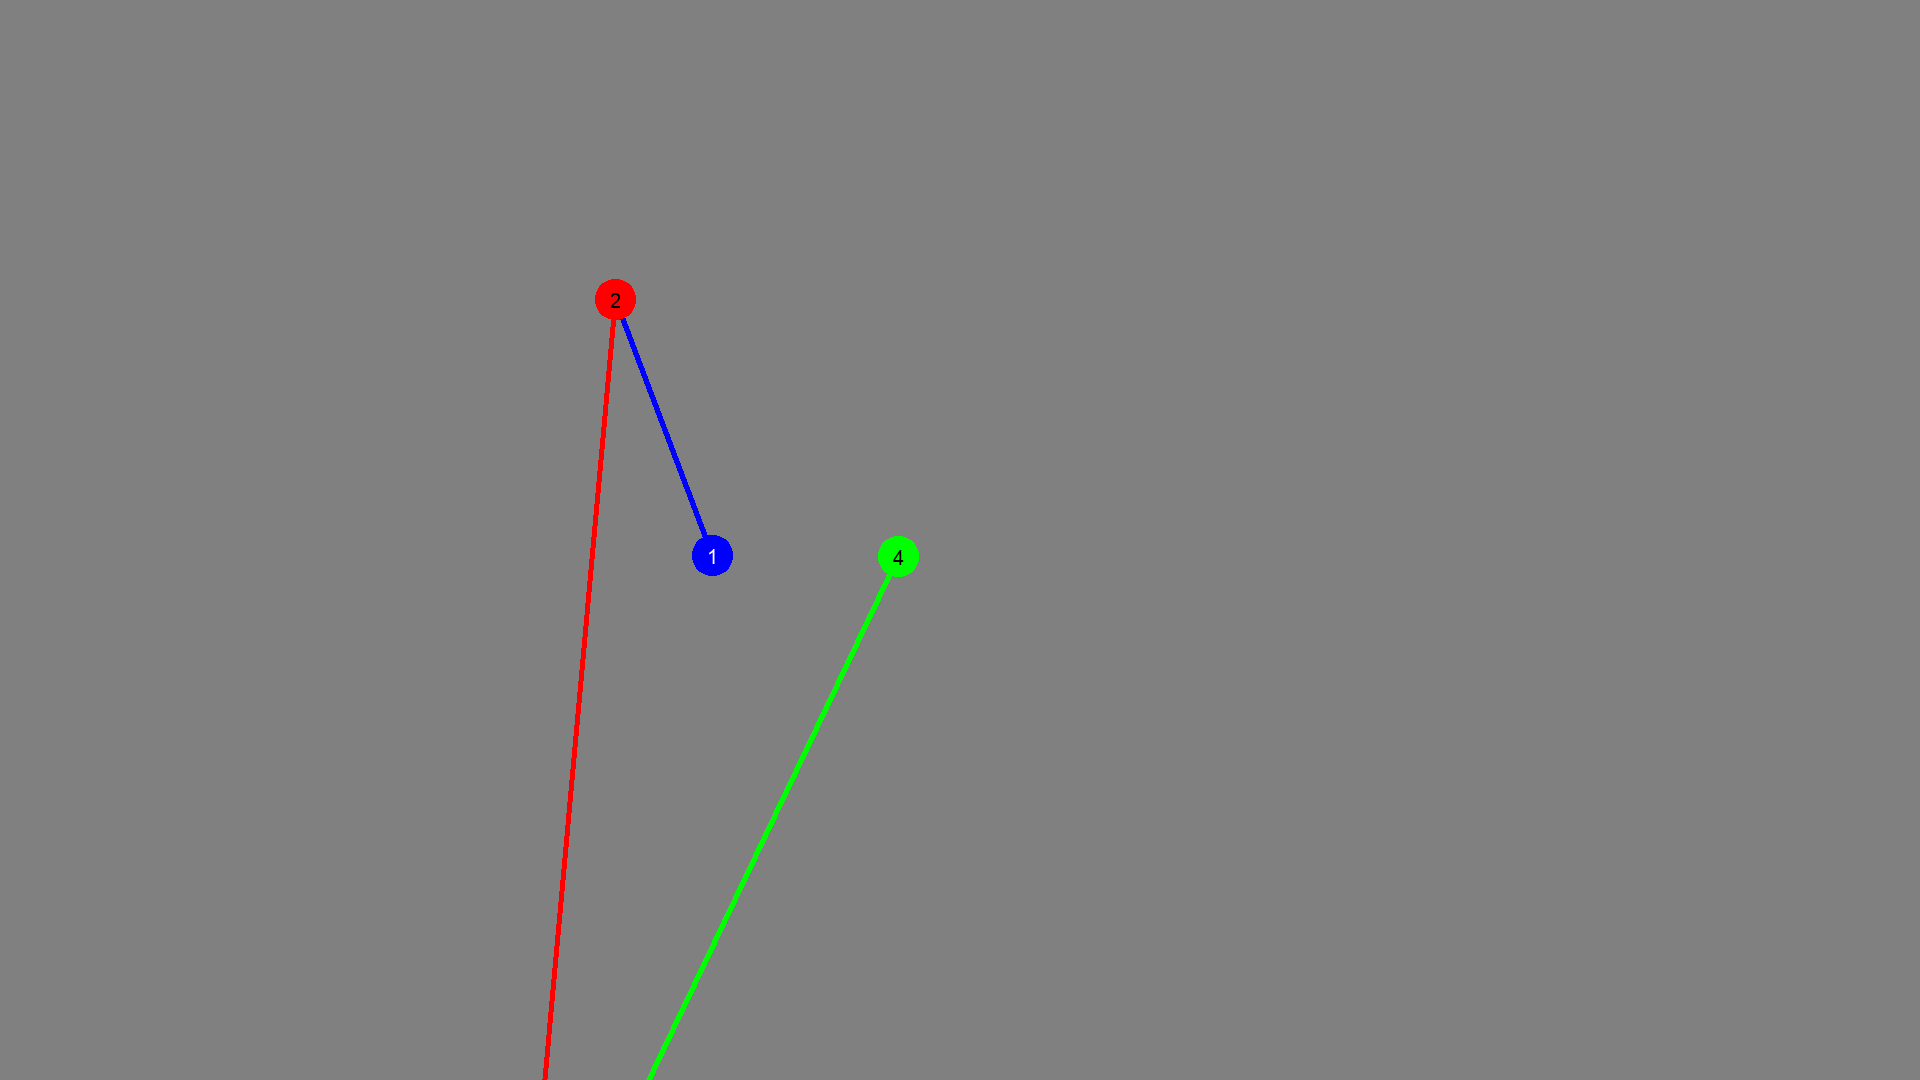

In [35]:
graphics.draw_scanpath(Image.new("RGB", (1920, 1080), "gray"), [
    [712, 555],
    [615, 299],
    [520, 1349],
    [898, 556]
])

Here we have a blink AND the end of the trial, which means the participant tends to look down to press the space bar to end the trial. So this outsider is a blink matter too.

## Single participant: PART_710

In [36]:
df710 = alld.query("PART_ID == 710").copy()
df710.shape

(3201, 31)

In [37]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_X < 0")["EYE_USED"].count()

0

In [38]:
# Number of looks on the RIGHT of the screen
df1.query("CURRENT_FIX_X > 1920")["EYE_USED"].count()

2

In [39]:
# Number of looks on the TOP of the screen
df1.query("CURRENT_FIX_Y < 0")["EYE_USED"].count()

0

In [40]:
# Number of looks on the BOTTOM of the screen
df1.query("CURRENT_FIX_Y > 1080")["EYE_USED"].count()

0

**DOWN**

This situation looks similar to previous participant. Let's see the condition to know if this is related to space bar

In [41]:
df1.query("CURRENT_FIX_Y > 1080")["CONDITION"].unique()

array([], dtype=int64)

These are TF tasks. Let's see if it is at the end of the trial

In [42]:
df1.query("CURRENT_FIX_Y > 1080")

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio


In [43]:
df1.ix[27989:27995]

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio


Conclusion: End of a TF trial AND blinks in both directions !

**UP**

In [44]:
# Number of looks on the TOP of the screen
df710.query("CURRENT_FIX_Y < 0")["EYE_USED"].count()

85

In [45]:
# Number of looks on the TOP of the screen
df710.query("CURRENT_FIX_Y < 0")["CONDITION"].value_counts()

4    40
2    12
6    11
3    10
5     8
1     4
Name: CONDITION, dtype: int64

In [46]:
# Percentage of TF tasks
(44+14+6)*100/87

73.5632183908046

In [47]:
# Number of looks on the TOP of the screen
df1.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_DURATION <= 120")["EYE_USED"].count()

0

-- UP -- 
On 85, 0(0.0%) where blinks
Mean distance is -135.0 (-4.0°)
Mean start time is 17.0s


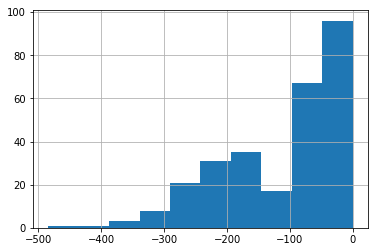

In [48]:
t = df710.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].count()
c = df710.query("CURRENT_FIX_Y < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = df710.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].mean()
s = df710.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_START"].mean()
print("-- UP -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].hist()

# Other

In [90]:
alld.query("CURRENT_FIX_DURATION < 120 and CURRENT_FIX_BLINK_AROUND == 'NONE'")["TRIAL_INDEX"].count()

5506

In [50]:
alld.query("CURRENT_FIX_DURATION < 120 and CURRENT_FIX_BLINK_AROUND != 'NONE'")["TRIAL_INDEX"].count()

74

In [91]:
alld.query("CURRENT_FIX_DURATION < 120 and CURRENT_FIX_BLINK_AROUND == 'AFTER'")["TRIAL_INDEX"].count()

0

In [92]:
alld.query("CURRENT_FIX_DURATION < 120 and CURRENT_FIX_BLINK_AROUND == 'BEFORE'")["TRIAL_INDEX"].count()

74

In [93]:
alld.query("CURRENT_FIX_DURATION < 120 and CURRENT_FIX_BLINK_AROUND == 'BOTH'")["TRIAL_INDEX"].count()

0

-- LEFT -- 
On 84, 0(0.0%) where blinks
Mean distance is -96.0 (-3.0°)
Mean start time is 15.0s


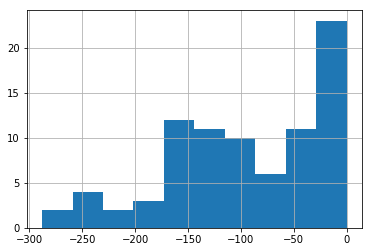

In [51]:
t = alld.query("CURRENT_FIX_X < 0")["EYE_USED"].count()
c = alld.query("CURRENT_FIX_X < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["EYE_USED"].count()
d = alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_X"].mean()
s = alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_START"].mean()
print("-- LEFT -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_X"].hist()

-- RIGHT -- 
On 76, 0(0.0%) where blinks
Mean distance is 77.0 (2.0°)
Mean start time is 35.0s


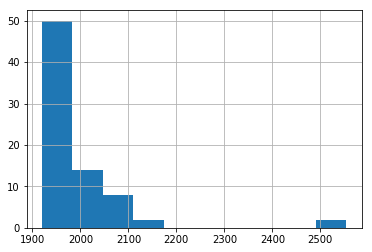

In [52]:
t = alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].count()
c = alld.query("CURRENT_FIX_X > 1920").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_X"].count()
d = (alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"] - 1920).mean()
s = alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_START"].mean()
print("-- RIGHT -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].hist()

-- UP -- 
On 280, 0(0.0%) where blinks
Mean distance is -110.0 (-3.0°)
Mean start time is 19.0s


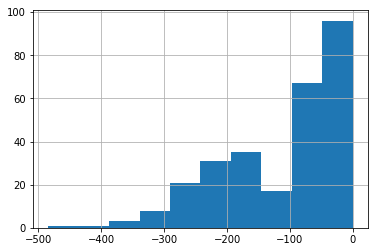

In [53]:
t = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].count()
c = alld.query("CURRENT_FIX_Y < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].mean()
s = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_START"].mean()
print("-- UP -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].hist()

-- DOWN -- 
On 40, 0(0.0%) where blinks
Mean distance is 148.0 (4.0°)
Mean start time is 44.0s


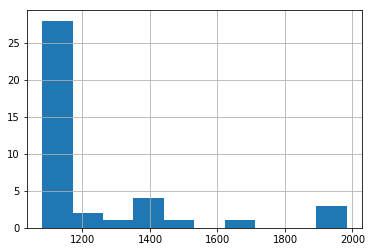

In [54]:
t = alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].count()
c = alld.query("CURRENT_FIX_Y > 1080").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = (alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"] - 1080).mean()
s = alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_START"].mean()
print("-- DOWN -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].hist()

In [55]:
alld.query("CURRENT_FIX_Y > 1080").groupby("CONDITION")["CURRENT_FIX_Y"].count()

CONDITION
2     1
4    16
5     6
6    17
Name: CURRENT_FIX_Y, dtype: int64

In [56]:
alld.query("CURRENT_FIX_Y < 0").groupby("CONDITION")["CURRENT_FIX_Y"].count()

CONDITION
1    62
2    53
3    35
4    74
5    24
6    32
Name: CURRENT_FIX_Y, dtype: int64

In [57]:
alld.query("CURRENT_FIX_X < 0").groupby("CONDITION")["CURRENT_FIX_X"].count()

CONDITION
1    27
2     2
3    12
4    16
5    13
6    14
Name: CURRENT_FIX_X, dtype: int64

In [58]:
alld.query("CURRENT_FIX_X > 1920").groupby("CONDITION")["CURRENT_FIX_X"].count()

CONDITION
1    10
2    12
3    22
4     7
5    11
6    14
Name: CURRENT_FIX_X, dtype: int64

In [59]:
alld.groupby("CONDITION")["CURRENT_FIX_START"].mean()

CONDITION
1    28080.112212
2    27287.867561
3    28508.171929
4    28319.284013
5    28193.395588
6    30261.392862
Name: CURRENT_FIX_START, dtype: float64

In [60]:
(2000-1920)/35

2.2857142857142856

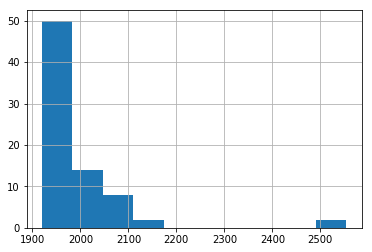

In [61]:
alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].hist()

In [62]:
print("Out of the zone:")
alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_X < -180")["EYE_USED"].count()

Out of the zone:


9

In [63]:
print("In the zone:")
alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_X > -180")["EYE_USED"].count()

In the zone:


75

In [64]:
print("In the zone:")
alld.query("CURRENT_FIX_X > 1920 and CURRENT_FIX_X < 2095")["EYE_USED"].count()

In the zone:


68

In [65]:
print("Out of the zone:")
alld.query("CURRENT_FIX_X > 1920 and CURRENT_FIX_X > 2095")["EYE_USED"].count()

Out of the zone:


8

In [66]:
print("In the zone:")
alld.query("CURRENT_FIX_Y > 1080 and CURRENT_FIX_Y < 1255")["EYE_USED"].count()

In the zone:


29

In [67]:
print("Out of the zone:")
alld.query("CURRENT_FIX_Y > 1080 and CURRENT_FIX_Y > 1255")["EYE_USED"].count()

Out of the zone:


11

In [68]:
print("Out of the zone:")
alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_Y < -180")["EYE_USED"].count()

Out of the zone:


78

In [69]:
print("In the zone:")
alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_Y > -180")["EYE_USED"].count()

In the zone:


202

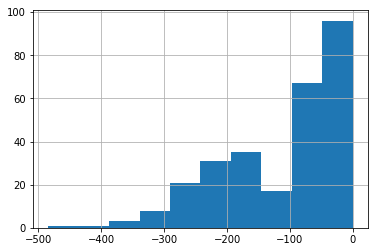

In [70]:
alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].hist()

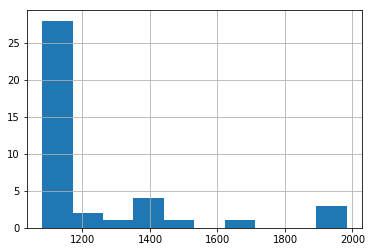

In [71]:
alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].hist()

In [72]:
5*35

175

In [73]:
alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_X > -180").groupby("TRIAL_INDEX")["EYE_USED"].count()

TRIAL_INDEX
2      1
3      1
4      5
5      1
6     10
7      4
8      2
9      4
11     7
12     7
14    21
17    12
Name: EYE_USED, dtype: int64

In [74]:
alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_Y > -180").groupby("TRIAL_INDEX")["EYE_USED"].count()

TRIAL_INDEX
1      6
2     11
3      7
4     11
5      2
7      4
8     21
9      6
10    12
11    16
12     7
13     7
14    36
15     9
16    13
17    18
18    16
Name: EYE_USED, dtype: int64

In [77]:
alld.query("CURRENT_FIX_Y > 1080")["EYE_USED"].count()

40

In [78]:
alld.query("CURRENT_FIX_X > 1920")["EYE_USED"].count()

76

In [79]:
alld.query("CURRENT_FIX_Y < 0")["EYE_USED"].count()

280

In [80]:
alld.query("CURRENT_FIX_X < 0")["EYE_USED"].count()

84

In [85]:
alld.query("CURRENT_FIX_Y > 1080").groupby(["PART_ID"])["EYE_USED"].count()

PART_ID
2       2
7       1
8       3
10      1
709    16
710     2
712     4
713     3
714     1
715     1
716     6
Name: EYE_USED, dtype: int64

In [86]:
alld.query("CURRENT_FIX_Y < 0").groupby(["PART_ID"])["EYE_USED"].count()

PART_ID
2      10
3       8
4       1
7      14
8       7
709     5
710    85
711    79
712    30
713    13
714     9
715    19
Name: EYE_USED, dtype: int64

In [88]:
alld.query("CURRENT_FIX_X > 1920").groupby(["PART_ID"])["EYE_USED"].count()

PART_ID
1       2
2       9
3       3
4      12
7       3
8       4
11      5
710     6
711     5
712    18
713     6
714     2
715     1
Name: EYE_USED, dtype: int64

In [89]:
alld.query("CURRENT_FIX_X < 0").groupby(["PART_ID"])["EYE_USED"].count()

PART_ID
2       3
11      8
709     7
710    18
711    18
712     1
713     2
714     1
716    26
Name: EYE_USED, dtype: int64

-- LEFT -- 
On 84, 0(0.0%) where blinks
Mean distance is -96.0 (-3.0°)
Number of fix within the 3°: 46 (54.76%)
Mean start time is 15.0s


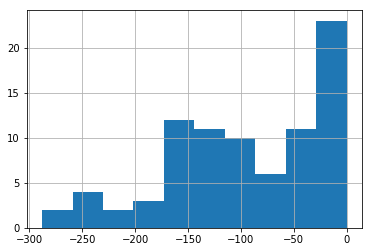

In [108]:
t = alld.query("CURRENT_FIX_X < 0")["EYE_USED"].count()
l = alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_X > -100")["CURRENT_FIX_X"].count()
c = alld.query("CURRENT_FIX_X < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["EYE_USED"].count()
d = alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_X"].mean()
s = alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_START"].mean()
print("-- LEFT -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Number of fix within the 3°: {} ({}%)".format(l, round(l*100/t, 2)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_X"].hist()

-- RIGHT -- 
On 76, 0(0.0%) where blinks
Mean distance is 77.0 (2.0°)
Number of fix within the 3°: 61 (80.26%)
Mean start time is 35.0s


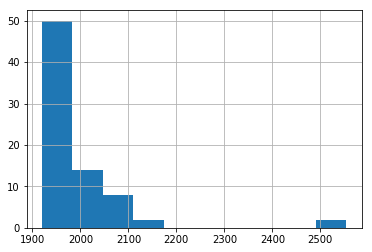

In [107]:
t = alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].count()
l = alld.query("CURRENT_FIX_X > 1920 and CURRENT_FIX_X < 2020")["CURRENT_FIX_X"].count()
c = alld.query("CURRENT_FIX_X > 1920").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_X"].count()
d = (alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"] - 1920).mean()
s = alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_START"].mean()
print("-- RIGHT -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Number of fix within the 3°: {} ({}%)".format(l, round(l*100/t, 2)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].hist()

-- UP -- 
On 280, 0(0.0%) where blinks
Mean distance is -110.0 (-3.0°)
Number of fix within the 3°: 165 (58.93%)
Mean start time is 19.0s


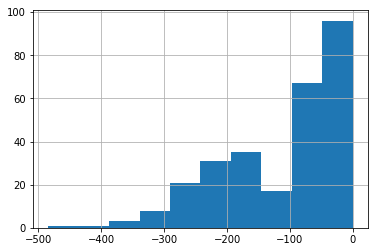

In [105]:
t = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].count()
l = alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_Y > -100")["CURRENT_FIX_Y"].count()
c = alld.query("CURRENT_FIX_Y < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].mean()
s = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_START"].mean()
print("-- UP -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Number of fix within the 3°: {} ({}%)".format(l, round(l*100/t, 2)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].hist()

-- DOWN -- 
On 40, 0(0.0%) where blinks
Mean distance is 148.0 (4.0°)
Number of fix within the 3°: 28 (70.0%)
Mean start time is 44.0s


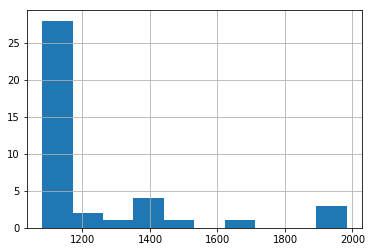

In [106]:
t = alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].count()
l = alld.query("CURRENT_FIX_Y > 1080 and CURRENT_FIX_Y < 1180")["CURRENT_FIX_Y"].count()
c = alld.query("CURRENT_FIX_Y > 1080").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = (alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"] - 1080).mean()
s = alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_START"].mean()
print("-- DOWN -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Number of fix within the 3°: {} ({}%)".format(l, round(l*100/t, 2)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].hist()

In [103]:
alld.query("CURRENT_FIX_DURATION < 120")["EYE_USED"].count()

5580

In [102]:
alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_DURATION < 120")

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio
723,No,4,BEFORE,48,10418.0,10371.0,1061.2,-7.2,2018-03-27 11:02:50.298,Skin,...,28.0,922.8,42.1,2600,713,Target,5,2,2592.8,0.010830
12287,No,2,NONE,104,67823.0,67720.0,1863.6,-200.0,2018-03-27 15:14:20.757,NoAd,...,13.0,1865.0,-198.4,2745,715,Target,16,2,2545.0,0.033482
12291,No,2,NONE,113,68477.0,68365.0,1550.2,-86.1,2018-03-27 15:14:21.402,NoAd,...,73.0,940.7,-22.4,2293,715,Target,16,2,2206.9,0.033482
20965,No,1,NONE,93,16247.0,16155.0,2029.2,-117.6,2018-04-03 16:14:25.149,NoAd,...,115.0,-39.4,31.8,900,2,Free,11,2,782.4,0.027907
24540,No,5,NONE,94,5392.0,5299.0,1833.9,-163.0,2018-04-03 17:39:09.629,SkinMpu,...,26.0,1794.8,-211.8,200,3,Free,12,15,37.0,0.009009
33557,No,2,NONE,29,5584.0,5556.0,1506.1,-220.8,2018-03-20 13:59:59.001,NoAd,...,46.0,1406.8,13.0,1000,710,Target,6,3,779.2,0.008000
33709,No,4,NONE,109,4169.0,4061.0,1449.1,-78.7,2018-03-20 14:03:13.054,Skin,...,6.0,1437.1,-50.0,0,710,Target,8,10,-78.7,0.054422
33710,No,4,NONE,61,4236.0,4176.0,1437.1,-50.0,2018-03-20 14:03:13.169,Skin,...,15.0,1448.1,-74.3,0,710,Target,8,10,-50.0,0.054422
33711,No,4,NONE,53,4304.0,4252.0,1448.1,-74.3,2018-03-20 14:03:13.245,Skin,...,23.0,1400.4,-23.3,0,710,Target,8,10,-74.3,0.054422
33714,No,4,NONE,26,5159.0,5134.0,1437.4,-8.4,2018-03-20 14:03:14.283,Skin,...,17.0,1424.4,13.9,0,710,Target,8,10,-8.4,0.054422


In [101]:
alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_DURATION < 120")

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio
34807,No,4,NONE,35,8803.0,8769.0,-1.2,-182.2,2018-03-20 14:12:08.621,Skin,...,6.0,9.2,-161.9,0,710,Target,14,2,-182.2,0.230216
34818,No,4,NONE,61,11549.0,11489.0,-143.7,-260.8,2018-03-20 14:12:11.341,Skin,...,78.0,607.6,378.1,499,710,Target,14,2,238.2,0.230216
37894,No,1,NONE,35,8803.0,8769.0,-1.2,-182.2,2018-03-20 16:25:17.620,NoAd,...,6.0,9.2,-161.9,0,711,Free,14,10,-182.2,0.217687
37905,No,1,NONE,61,11549.0,11489.0,-143.7,-260.8,2018-03-20 16:25:20.340,NoAd,...,78.0,607.6,378.1,300,711,Free,14,10,39.2,0.217687
39953,No,6,NONE,113,2480.0,2368.0,-68.9,155.8,2018-04-03 14:03:03.362,SkinMpu,...,21.0,-151.5,163.6,0,716,Target,6,12,155.8,0.012821
42514,No,1,NONE,90,2297.0,2208.0,-231.4,219.5,2018-04-03 14:20:39.202,NoAd,...,67.0,508.4,516.2,0,716,Free,17,2,219.5,0.041985
42534,No,1,NONE,104,5996.0,5893.0,-131.6,221.2,2018-04-03 14:20:42.887,NoAd,...,36.0,80.6,179.8,0,716,Free,17,2,221.2,0.041985


In [100]:
alld.query("CURRENT_FIX_X > 1920 and CURRENT_FIX_DURATION < 120")

,CALIBRATION_PROBLEM,CONDITION,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_DURATION,CURRENT_FIX_END,CURRENT_FIX_START,CURRENT_FIX_X,CURRENT_FIX_Y,DATETIME,DISTRACTOR,...,NEXT_SAC_DURATION,NEXT_SAC_END_X,NEXT_SAC_END_Y,OFFSET,PART_ID,TASK,TRIAL_INDEX,WEBSITE_ID,Y_OFFSET,error_ratio
8096,No,3,NONE,74,23933.0,23860.0,1953.7,497.6,2018-03-27 14:01:57.663,Skin,...,99.0,965.2,711.5,1900,714,Free,13,1,2397.6,0.008889
13418,No,5,NONE,76,7985.0,7910.0,2002.0,416.7,2018-07-19 16:20:34.600,SkinMpu,...,111.0,826.4,739.4,1200,11,Free,3,2,1616.7,0.013100
16661,No,3,NONE,46,29269.0,29224.0,1970.1,60.9,2018-03-27 09:57:05.293,Skin,...,77.0,1857.8,791.9,3100,712,Free,4,1,3160.9,0.034483
19109,No,3,NONE,103,14008.0,13906.0,2554.3,98.8,2018-04-03 15:56:36.900,Skin,...,65.0,2529.0,88.6,1400,2,Free,1,7,1498.8,0.008658
19110,No,3,NONE,30,14103.0,14074.0,2529.0,88.6,2018-04-03 15:56:37.068,Skin,...,123.0,1096.8,820.9,1400,2,Free,1,7,1488.6,0.008658
20965,No,1,NONE,93,16247.0,16155.0,2029.2,-117.6,2018-04-03 16:14:25.149,NoAd,...,115.0,-39.4,31.8,900,2,Free,11,2,782.4,0.027907
25876,No,2,NONE,76,24167.0,24092.0,1944.5,830.8,2018-04-10 15:40:34.034,NoAd,...,72.0,1334.7,812.0,8300,4,Target,1,18,9130.8,0.032468
43572,No,2,NONE,113,NaN,31337.0,1930.8,281.8,2018-04-03 14:56:31.574,NoAd,...,61.0,1881.5,573.5,5937,1,Target,3,3,6218.8,0.006645
49193,No,2,NONE,64,3713.0,3650.0,1971.0,-117.6,2018-04-24 17:14:26.643,NoAd,...,17.0,1940.8,-81.3,0,8,Target,13,13,-117.6,0.006250
49707,No,2,NONE,23,2181.0,2159.0,2015.3,-120.8,2018-04-24 17:18:07.152,NoAd,...,16.0,2018.3,-119.3,0,8,Target,15,2,-120.8,0.024490


In [112]:
alld.query("CURRENT_FIX_Y > 1080")[["TRIAL_INDEX", "WEBSITE_ID", "PART_ID", "CONDITION", "CURRENT_FIX_Y", "CURRENT_FIX_START"]]


,TRIAL_INDEX,WEBSITE_ID,PART_ID,CONDITION,CURRENT_FIX_Y,CURRENT_FIX_START
1496,9,8,713,5,1100.4,45204.0
1497,9,8,713,5,1095.2,45394.0
2569,16,12,713,6,1080.6,6772.0
4823,11,13,10,4,1111.7,24892.0
6158,2,2,714,6,1107.1,37927.0
11418,12,12,715,4,1132.8,14262.0
17109,7,5,712,6,1130.1,37484.0
18246,13,8,712,5,1083.6,38235.0
18247,13,8,712,5,1084.9,38334.0
18373,14,2,712,4,1087.5,20054.0


In [119]:
alld.iloc[1495:1533][["TRIAL_INDEX", "WEBSITE_ID", "PART_ID", "CONDITION", "CURRENT_FIX_Y", "CURRENT_FIX_START"]]

,TRIAL_INDEX,WEBSITE_ID,PART_ID,CONDITION,CURRENT_FIX_Y,CURRENT_FIX_START
1495,9,8,713,5,1014.0,45026.0
1496,9,8,713,5,1100.4,45204.0
1497,9,8,713,5,1095.2,45394.0
1498,9,8,713,5,692.1,45548.0
1499,9,8,713,5,719.7,45842.0
1500,9,8,713,5,717.2,45945.0
1501,9,8,713,5,717.9,46172.0
1502,9,8,713,5,730.6,46345.0
1503,9,8,713,5,714.3,46620.0
1504,9,8,713,5,713.8,46829.0


In [130]:
alld.query("CURRENT_FIX_Y > 1080 or CURRENT_FIX_Y < 0 or CURRENT_FIX_X > 1920 or CURRENT_FIX_X < 0")["EYE_USED"].count()

420

In [133]:
def compute_advances_Y_1080(group):
    last_row = group.tail(1).fillna(0)
    end_time = last_row["CURRENT_FIX_START"].values[0] + last_row["CURRENT_FIX_DURATION"].values[0] + last_row["NEXT_SAC_DURATION"].values[0]
    
    group["TIME_POS"] = group["CURRENT_FIX_START"] * 100 / end_time
    group["REMAINING_TIME"] = end_time - group["CURRENT_FIX_START"]
    group["DISTANCE_Y"] = group["CURRENT_FIX_Y"] - 1080
    group["DEG"] = group["DISTANCE"]/35
    
    return group

def compute_advances_Y_0(group):
    last_row = group.tail(1).fillna(0)
    end_time = last_row["CURRENT_FIX_START"].values[0] + last_row["CURRENT_FIX_DURATION"].values[0] + last_row["NEXT_SAC_DURATION"].values[0]
    
    group["TIME_POS"] = group["CURRENT_FIX_START"] * 100 / end_time
    group["REMAINING_TIME"] = end_time - group["CURRENT_FIX_START"]
    group["DISTANCE_Y"] = np.abs(group["CURRENT_FIX_Y"])
    group["DEG"] = group["DISTANCE"]/35
    
    return group

alld = alld.groupby(["PART_ID", "TRIAL_INDEX"]).apply(compute_advances)

In [134]:
alld.query("CURRENT_FIX_Y > 1080 or CURRENT_FIX_Y < 0 or CURRENT_FIX_X > 1920 or CURRENT_FIX_X < 0")["DEG"]

112     -21.797143
202     -32.451429
203     -31.962857
204     -31.188571
350     -23.937143
351     -19.182857
415     -32.668571
416     -31.468571
419     -30.905714
535     -22.640000
714     -28.971429
722     -31.420000
723     -31.062857
1259    -31.945714
1408    -14.745714
1425    -32.100000
1449    -23.951429
1496      0.582857
1497      0.434286
1588    -33.362857
1589    -34.382857
2051    -30.814286
2246    -32.800000
2569      0.017143
4823      0.905714
6027    -31.445714
6046    -30.994286
6054    -34.294286
6158      0.774286
6180    -33.382857
           ...    
42558   -24.740000
42559   -24.545714
42896     9.831429
43572   -22.805714
43577   -28.151429
47206    25.785714
47207    25.525714
49193   -34.217143
49194   -33.180000
49704   -31.351429
49705   -31.094286
49706   -31.054286
49707   -34.308571
49708   -34.265714
49791     0.522857
50701   -31.062857
50703   -31.642857
50704   -31.345714
50878   -31.791429
52365   -30.862857
52366   -31.282857
52367   -31.